In [2]:
from pyspark.sql.functions import *       # added for the function 
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from operator import add


from datetime import datetime

spark = SparkSession.builder \
    .master('local') \
    .appName('WeeklyDelays') \
    .getOrCreate()

# Functions to add a 0 to days/months to make dates sortable
def formatDecimal(n):
    if len(n) == 1:
        return '0' + n
    else: 
        return n
    
def formatDate(n):
    n = n.split('-')
    return n[0]+'-'+formatDecimal(n[1])
    
def getWeek(y,m,d):
    return datetime(y,m,d).isocalendar()[1]

allflights = spark.read.load("./data/alldata.csv",format="csv", sep=",", header="true")

df = allflights.select("Year", "Month", "DayofMonth", "ArrDelay", "DepDelay", "WeatherDelay")

df = df.withColumn("Year", df["Year"].cast(IntegerType()))
df = df.withColumn("Month", df["Month"].cast(IntegerType()))
df = df.withColumn("DayofMonth", df["DayofMonth"].cast(IntegerType()))
df = df.withColumn("ArrDelay", df["ArrDelay"].cast(FloatType()))
df = df.withColumn("DepDelay", df["DepDelay"].cast(FloatType()))
df = df.withColumn("WeatherDelay", df["WeatherDelay"].cast(FloatType()))

df = df.filter((df['ArrDelay'] > 0)|(df['DepDelay'] > 0)) #Only flights with a delay are interesting
df = df.where(col("Year").isNotNull() & col("Month").isNotNull() & col("DayofMonth").isNotNull() & col("ArrDelay").isNotNull() & col("DepDelay").isNotNull())
#df.show(100)

+----+-----+----------+--------+--------+------------+
|Year|Month|DayofMonth|ArrDelay|DepDelay|WeatherDelay|
+----+-----+----------+--------+--------+------------+
|1994|    1|        10|    20.0|    35.0|        null|
|1994|    1|        11|    88.0|     3.0|        null|
|1994|    1|        12|    21.0|    33.0|        null|
|1994|    1|        14|     2.0|     3.0|        null|
|1994|    1|        15|     1.0|    -1.0|        null|
|1994|    1|        18|    -4.0|     4.0|        null|
|1994|    1|        20|    12.0|    23.0|        null|
|1994|    1|        24|     3.0|     1.0|        null|
|1994|    1|        27|     5.0|    10.0|        null|
|1994|    1|        28|    17.0|    -2.0|        null|
|1994|    1|        31|     3.0|     4.0|        null|
|1994|    1|         1|     2.0|     2.0|        null|
|1994|    1|         2|    -2.0|     5.0|        null|
|1994|    1|         3|    -1.0|    10.0|        null|
|1994|    1|         4|     3.0|     6.0|        null|
|1994|    

In [11]:
#Number of flights with a weather delay per week
df = df.where(col("WeatherDelay").isNotNull())
WeatherDelaysPerWeek = df.rdd.map(lambda r: (r[0],getWeek(r[0],r[1],r[2]), r[5])).toDF()
WeatherDelaysPerWeek = WeatherDelaysPerWeek.select(concat(col("_1"), lit("-"), col("_2")).alias('Date'), col("_3").alias("WeatherDelays"))
WeatherDelaysPerWeek = WeatherDelaysPerWeek.filter(WeatherDelaysPerWeek["WeatherDelays"] > 0)
WeatherDelaysPerWeek = WeatherDelaysPerWeek.rdd.map(lambda x: (formatDate(x[0]), 1)) \
                                                .reduceByKey(lambda x, y: x+y) \
                                                .sortByKey().toDF()
WeatherDelaysPerWeek = WeatherDelaysPerWeek.select(col("_1").alias("Date"), col("_2").alias("WeatherDelays"))
#WeatherDelaysPerWeek.show(400)

+-------+-------------+
|   Date|WeatherDelays|
+-------+-------------+
|2003-01|          448|
|2003-22|           85|
|2003-23|         1332|
|2003-24|         2702|
|2003-25|         1836|
|2003-26|          868|
|2003-27|         1807|
|2003-28|         2602|
|2003-29|         1240|
|2003-30|         2331|
|2003-31|         2678|
|2003-32|         2467|
|2003-33|         1868|
|2003-34|         1278|
|2003-35|         2036|
|2003-36|          859|
|2003-37|         1099|
|2003-38|          813|
|2003-39|          764|
|2003-40|          382|
|2003-41|          722|
|2003-42|          437|
|2003-43|          521|
|2003-44|          615|
|2003-45|         1501|
|2003-46|         1412|
|2003-47|         2029|
|2003-48|          640|
|2003-49|         2036|
|2003-50|         2617|
|2003-51|         1332|
|2003-52|         1263|
|2004-01|         2103|
|2004-02|         2773|
|2004-03|         2632|
|2004-04|         1840|
|2004-05|         4126|
|2004-06|         3462|
|2004-07|       

In [5]:
#Number of flights with a delay per week
DelaysPerWeek = df.rdd.map(lambda r: (r[0],getWeek(r[0],r[1],r[2]), r[3], r[4])).toDF()
DelaysPerWeek = DelaysPerWeek.select(concat(col("_1"), lit("-"), col("_2")).alias("Date"))
DelaysPerWeek = DelaysPerWeek.rdd.map(lambda x: (formatDate(x[0]), 1))\
                                                .reduceByKey(lambda x, y: x+y) \
                                                .sortByKey().toDF()
DelaysPerWeek = DelaysPerWeek.select(col("_1").alias("DelayDate"), col("_2").alias("FlightDelays"))
#DelaysPerWeek.show(100)

+---------+------------+
|DelayDate|FlightDelays|
+---------+------------+
|  2003-01|       28797|
|  2003-22|        6426|
|  2003-23|       51190|
|  2003-24|       60723|
|  2003-25|       62831|
|  2003-26|       59381|
|  2003-27|       51179|
|  2003-28|       66125|
|  2003-29|       59832|
|  2003-30|       64485|
|  2003-31|       64988|
|  2003-32|       65360|
|  2003-33|       64041|
|  2003-34|       52330|
|  2003-35|       52567|
|  2003-36|       45946|
|  2003-37|       47586|
|  2003-38|       45275|
|  2003-39|       46567|
|  2003-40|       43537|
|  2003-41|       49786|
|  2003-42|       51618|
|  2003-43|       50063|
|  2003-44|       54050|
|  2003-45|       61481|
|  2003-46|       59653|
|  2003-47|       61623|
|  2003-48|       55065|
|  2003-49|       64186|
|  2003-50|       63236|
|  2003-51|       75048|
|  2003-52|       66374|
|  2004-01|       43806|
|  2004-02|       70667|
|  2004-03|       62802|
|  2004-04|       59115|
|  2004-05|       67975|


In [6]:
## Join the three tables to have each row contain the total and total canceled flights
Delays = WeatherDelaysPerWeek.join(DelaysPerWeek, DelaysPerWeek.DelayDate == WeatherDelaysPerWeek.Date, how='left').drop("DelayDate").na.fill(0)
Delays = Delays.withColumn("WeatherDelays", Delays["WeatherDelays"].cast(FloatType()))
Delays = Delays.withColumn("FlightDelays", Delays["FlightDelays"].cast(FloatType()))
Delays = Delays.sort(col("Date").asc())
#Delays.show(100)

+-------+-------------+------------+
|   Date|WeatherDelays|FlightDelays|
+-------+-------------+------------+
|2003-01|        448.0|     28797.0|
|2003-22|         85.0|      6426.0|
|2003-23|       1332.0|     51190.0|
|2003-24|       2702.0|     60723.0|
|2003-25|       1836.0|     62831.0|
|2003-26|        868.0|     59381.0|
|2003-27|       1807.0|     51179.0|
|2003-28|       2602.0|     66125.0|
|2003-29|       1240.0|     59832.0|
|2003-30|       2331.0|     64485.0|
|2003-31|       2678.0|     64988.0|
|2003-32|       2467.0|     65360.0|
|2003-33|       1868.0|     64041.0|
|2003-34|       1278.0|     52330.0|
|2003-35|       2036.0|     52567.0|
|2003-36|        859.0|     45946.0|
|2003-37|       1099.0|     47586.0|
|2003-38|        813.0|     45275.0|
|2003-39|        764.0|     46567.0|
|2003-40|        382.0|     43537.0|
|2003-41|        722.0|     49786.0|
|2003-42|        437.0|     51618.0|
|2003-43|        521.0|     50063.0|
|2003-44|        615.0|     54050.0|
|

In [14]:
DelaysPercentage = Delays.rdd.map(lambda r: (r[0], r[1], r[2], (r[1]/r[2])*100)).sortBy(lambda x: -x[3]).toDF()
DelaysPercentage = DelaysPercentage.select(col("_1").alias("Date"), col("_2").alias("WeatherDelays"), col("_3").alias("FlightDelays") \
    , col("_4").alias("Percentage"))
DelaysPercentage.show(100)

+-------+-------------+------------+------------------+
|   Date|WeatherDelays|FlightDelays|        Percentage|
+-------+-------------+------------+------------------+
|2008-51|       7180.0|     54775.0| 13.10816978548608|
|2008-52|       5092.0|     48213.0|  10.5614668243005|
|2008-25|       3538.0|     37253.0|  9.49722170026575|
|2008-10|       3708.0|     40606.0| 9.131655420381223|
|2008-05|       3205.0|     35638.0|  8.99320949548235|
|2008-07|       3458.0|     39066.0| 8.851686888854758|
|2008-28|       3249.0|     39097.0| 8.310100519221423|
|2008-33|       2348.0|     30083.0| 7.805072632383739|
|2008-50|       2145.0|     27626.0| 7.764424817201188|
|2008-08|       3173.0|     41191.0| 7.703139035226142|
|2008-30|       2606.0|     34156.0| 7.629699027989226|
|2008-03|       2069.0|     27421.0| 7.545311987163124|
|2008-26|       3038.0|     40725.0|7.4597912829957025|
|2008-06|       2649.0|     35853.0| 7.388503054137729|
|2008-32|       2398.0|     33070.0|  7.25128515

Text(0,0.5,'Percentage')

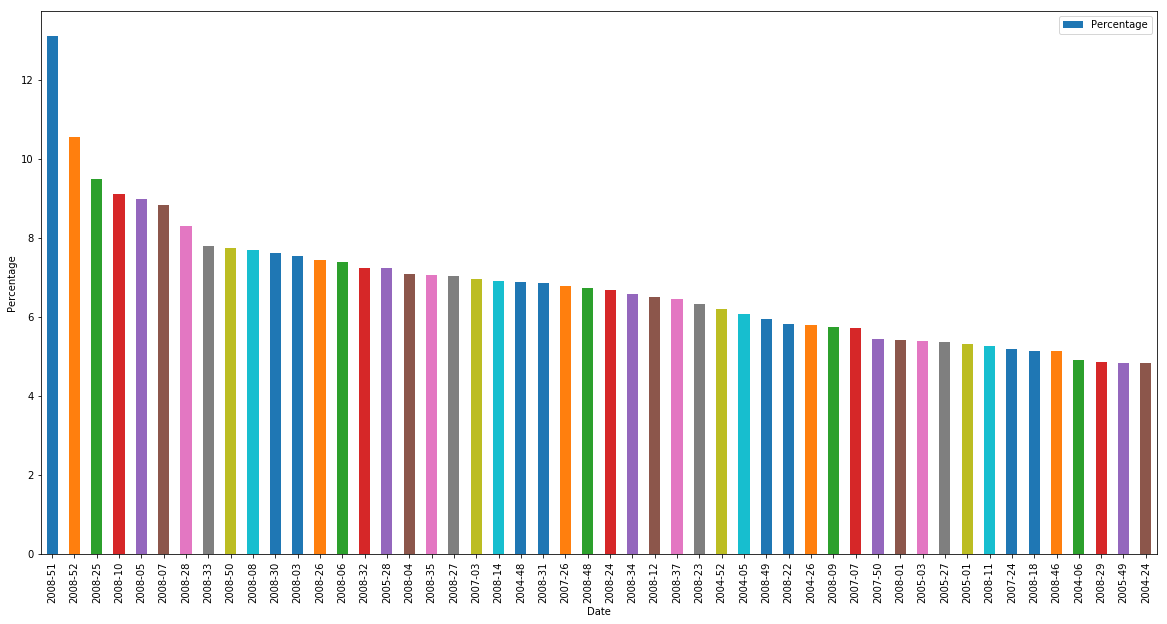

In [15]:
import matplotlib
import matplotlib.pyplot as plt

Stats = DelaysPercentage.toPandas()

ax = Stats.head(50).plot.bar(x='Date', y='Percentage',figsize=(20, 10));
ax.set_ylabel("Percentage")

In [16]:
## Statistics 
highest = Stats.loc[Stats['Percentage'].idxmax()] # Day with highest Percentage WeatherDelays
#print(highest)
lowest = Stats.loc[Stats['Percentage'].idxmin()]  # Day with lowest Percentage WeatherDelays
#print(lowest)

summary = DelaysPercentage.describe('Percentage')
print('\nDay with highest Percentage WeatherDelays : %s with %.2f%%' % (highest[0], highest[3]))
print('Day with lowest Percentage WeatherDelays  : %s with %.2f%%\n' % (lowest[0], lowest[3]))
summary.show()


Day with highest Percentage WeatherDelays : 2008-51 with 13.11%
Day with lowest Percentage WeatherDelays  : 2004-39 with 0.52%

+-------+------------------+
|summary|        Percentage|
+-------+------------------+
|  count|               248|
|   mean| 3.555624185936191|
| stddev|1.9964216012297558|
|    min|0.5202106013886267|
|    max| 13.10816978548608|
+-------+------------------+

